# Debugging XGBoost training jobs in real time with Amazon SageMaker Debugger 

This notebook uses the MNIST dataset to demonstrate real-time analysis of XGBoost training jobs while the training jobs are running. 

This notebook was created and tested on an ml.m5.4xlarge notebook instance using 100GB instance volume. 

## Overview 

Amazon SageMaker Debugger is a new capability of Amazon SageMaker that allows debugging machine learning training.  
SageMaker Debugger helps you to monitor your training in near real time using rules and provides alerts if it detects an inconsistency in training.  

Using SageMaker Debugger is a two step process: Saving tensors and analysis. 
Let's look at each one of them closely. 

### Saving tensors

In deep learning algorithms, tensors define the state of the training job at any particular instant in its lifecycle.
Amazon SageMaker Debugger exposes a library which allows you to capture these tensors and save them for analysis.
Although XGBoost is not a deep learning algorithm, Amazon SageMaker Debugger is highly customizable and can help you interpret results by saving insightful metrics. For example, performance metrics or the importance of features at different frequencies. 
Refer to [documentation](https://github.com/awslabs/sagemaker-debugger/blob/master/docs/xgboost.md) for details on how to save the metrics you want. 


### Analysis

There are two ways to get to tensors and run analysis on them.

One way is to use concept called ***Rules***. On a very broad level, a rule is Python code used to detect certain conditions during training.
Some of the conditions that a data scientist training an algorithm may care about are monitoring for gradients getting too large or too small, detecting overfitting, and so on.
Amazon SageMaker Debugger comes pre-packaged with certain built-in rules that can be invoked on Amazon SageMaker. You can also write your own rules using the Amazon SageMaker Debugger APIs. 
For more details about automatic analysis using rules, see [rules documentation](https://github.com/awslabs/sagemaker-debugger/tree/master/docs/rules).

This notebook focuses on another approach: **Manual analysis**, which can be performed in realtime while training jobs are running.

Manual analysis is helpful to detect which type of issue you're running into. You save raw tensors in order to understand your data and model better and figure out the root cause of your training job problem.

Manual analysis is powered by the Amazon SageMaker Debugger API. This API framework enables retrieving tensors and scalars (e.g., debugging data) saved during training job via few lines of code. One of the most powerful features provided by it is realtime access to data. You can get tensors and scalars ***while your training job is running***.

![Animated confusion matrix](cm.gif)

In [1]:
# ! python -m pip install smdebug

In [2]:
import boto3
import sagemaker

Amazon SageMaker Debugger is available in Amazon SageMaker XGBoost container version `0.90-2` or later. If you want to use XGBoost with Amazon SageMaker Debugger, you have to specify `repo_version='0.90-2'` in the `get_image_uri` function.

In [3]:
from sagemaker.amazon.amazon_estimator import get_image_uri

# Below changes the region to be one where this notebook is running
region = boto3.Session().region_name
container = get_image_uri(region, "xgboost", repo_version="0.90-2")

## Training XGBoost models in Amazon SageMaker with Amazon SageMaker Debugger

In this section you learn to train an XGBoost model with Amazon SageMaker Debugger enabled and monitor the training jobs.
This is done using the SageMaker [Estimator API](https://sagemaker.readthedocs.io/en/stable/estimators.html#sagemaker.estimator.Estimator).
While training job is running use the SageMaker Debugger API to access saved tensors in real time and visualize them.
You can rely on SageMaker Debugger to take care of downloading fresh set of tensors every time we query for them.

This example is adapted from [XGBoost for Classification](https://github.com/awslabs/amazon-sagemaker/examples/tree/master/introduction_to_amazon_algorithms/xgboost_mnist).
Refer to [XGBoost for Classification](https://github.com/awslabs/amazon-sagemaker/examples/tree/master/introduction_to_amazon_algorithms/xgboost_mnist) for an example of using classification from Amazon SageMaker's implementation of [XGBoost](https://github.com/dmlc/xgboost).

### Data preparation

Use the [MNIST data](https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/multiclass.html) stored in [LIBSVM](https://www.csie.ntu.edu.tw/~cjlin/libsvm/) format.

In [5]:
from data_utils import load_mnist, upload_to_s3

bucket = sagemaker.Session().default_bucket()
prefix = "md-labs-xgboost-mnist-debugging"

In [6]:
%%time

train_file, validation_file = load_mnist()
upload_to_s3(train_file, bucket, f"{prefix}/train/mnist.train.libsvm")
upload_to_s3(validation_file, bucket, f"{prefix}/validation/mnist.validation.libsvm")

Writing to s3://sagemaker-us-east-2-868024899531/md-labs-xgboost-mnist-debugging/train/mnist.train.libsvm
Writing to s3://sagemaker-us-east-2-868024899531/md-labs-xgboost-mnist-debugging/validation/mnist.validation.libsvm
CPU times: user 3.23 s, sys: 587 ms, total: 3.81 s
Wall time: 4min 34s


### Enabling Amazon SageMaker Debugger in the estimator object

Enabling Amazon SageMaker Debugger in a training job can be accomplished by adding its configuration into an Estimator object constructor:

```
from sagemaker.debugger import DebuggerHookConfig

estimator = Estimator(
    ...,
    debugger_hook_config = DebuggerHookConfig(
        s3_output_path="s3://{bucket_name}/{location_in_bucket}",  # Required
        collection_configs=[
            CollectionConfig(
                name="metrics",
                parameters={
                    "save_interval": "10"
                }
            )
        ]
    )
)
```
Here, the `DebuggerHookConfig` object configures which data `Estimator` should save for the real-time visualization. Provide two parameters:

- `s3_output_path`: Points to an S3 bucket where you intend to store the debugging tensors. Amount of data saved depends on multiple factors, major ones are training job, data set, model, frequency of saving tensors. This bucket should be in your AWS account and you should have full access control over it. **Important**: This S3 bucket should be originally created in the same Region where your training job is running, otherwise you might run into problems with cross-Region access.

- `collection_configs`: It enumerates named collections of tensors to save. Collections are a convenient way to organize relevant tensors under same umbrella to make it easy to navigate them during analysis. In this particular example, you are interested in a single collection named `metrics`. You also configured Amazon SageMaker Debugger to save metrics every 10 iterations. For all parameters that are supported by Collections and DebuggerConfig, see [Collection documentation](https://github.com/awslabs/sagemaker-debugger/blob/master/docs/api.md).

### Using Amazon SageMaker Debugger with XGBoost Classification

Import the libraries for the demo of Amazon SageMaker Debugger.

In [7]:
from sagemaker import get_execution_role

# role = get_execution_role()
role = 'arn:aws:iam::868024899531:role/service-role/AmazonSageMaker-ExecutionRole-20200530T112594'
base_job_name = "md-labs-xgboost-classification-debugging"
bucket_path = 's3://{}'.format(bucket)

num_round = 25
save_interval = 3
hyperparameters={
    "max_depth": "5",
    "eta": "0.1",
    "gamma": "4",
    "min_child_weight": "6",
    "silent": "0",
    "objective": "multi:softmax",
    "num_class": "10",  # num_class is required for 'multi:*' objectives
    "num_round": num_round,
}


In [8]:
from sagemaker.estimator import Estimator
from sagemaker.debugger import DebuggerHookConfig, CollectionConfig

xgboost_algorithm_mode_estimator = Estimator(
    role=role,
    base_job_name=base_job_name,
    train_instance_count=1,
    train_instance_type='ml.m5.xlarge',
    image_name=container,
    hyperparameters=hyperparameters,
    train_max_run=1800,

    debugger_hook_config = DebuggerHookConfig(
        s3_output_path=bucket_path,  # Required
        collection_configs=[
            CollectionConfig(
                name="metrics",
                parameters={
                    "save_interval": str(save_interval)
                }
            ),
            CollectionConfig(
                name="predictions",
                parameters={
                    "save_interval": str(save_interval)
                }
            ),
            CollectionConfig(
                name="labels",
                parameters={
                    "save_interval": str(save_interval)
                }
            )
        ]
    )
)

With the next step you are going to actually start a training job using the Estimator object you created above. This job is started in asynchronous, non-blocking way. This means that control is passed back to the notebook and further commands can be run while training job is progressing.

In [9]:
from sagemaker.session import s3_input

train_s3_input = s3_input("s3://{}/{}/{}".format(bucket, prefix, "train"), content_type="libsvm")
validation_s3_input = s3_input("s3://{}/{}/{}".format(bucket, prefix, "validation"), content_type="libsvm")

# This is a fire and forget event. By setting wait=False, you just submit the job to run in the background.
# Amazon SageMaker will start one training job and release control to next cells in the notebook.
# Follow this notebook to see status of the training job.
xgboost_algorithm_mode_estimator.fit(
    {
        "train": train_s3_input,
        "validation": validation_s3_input
    },
    wait=False
)

### Result

As a result of the above command, Amazon SageMaker starts one training job for you and it produces the tensors to be analyzed.
This job will run in a background without you having to wait for it to complete in order to continue with the rest of the notebook.
Because of this asynchronous nature of a training job, you need to monitor its status so that you don't start to request debugging too early.


## Analysis and Visualization

### Checking on the training job status

Check the status of the training job by running the following code.
It checks on the status of an Amazon SageMaker training job every 15 seconds.
Once job has started its training cycle control is released to next cells in the notebook.
That means training job started to tune the model and, in parallel, emit debugging tensors.

In [10]:
import time
from time import gmtime, strftime


# Below command will give the status of training job
job_name = xgboost_algorithm_mode_estimator.latest_training_job.name
client = xgboost_algorithm_mode_estimator.sagemaker_session.sagemaker_client
description = client.describe_training_job(TrainingJobName=job_name)
print('Training job name: ' + job_name)

if description['TrainingJobStatus'] != 'Completed':
    while description['SecondaryStatus'] not in ['Training', 'Completed']:
        description = client.describe_training_job(TrainingJobName=job_name)
        primary_status = description['TrainingJobStatus']
        secondary_status = description['SecondaryStatus']
        print("{}: {}, {}".format(strftime('%X', gmtime()), primary_status, secondary_status))
        time.sleep(15)

Training job name: md-labs-xgboost-classification-debuggin-2020-05-30-20-55-56-297
20:56:36: InProgress, Starting
20:56:52: InProgress, Starting
20:57:07: InProgress, Starting
20:57:23: InProgress, Starting
20:57:38: InProgress, Downloading
20:57:53: InProgress, Downloading
20:58:09: InProgress, Training


### Retrieving and Analyzing tensors

Before getting to analysis, here are some notes on concepts being used in Amazon SageMaker Debugger that help with analysis.
# - ***Trial*** - Object that is a centerpiece of the SageMaker Debugger API when it comes to getting access to tensors. It is a top level abstract that represents a single run of a training job. All tensors emitted by a training job are associated with its *trial*.
# - ***Step*** - Object that represents next level of abstraction. In SageMaker Debugger, *step* is a representation of a single batch of a training job. Each trial has multiple steps. Each tensor is associated with multiple steps and has a particular value at each of the steps.
# - ***Tensor*** - object that represent actual *tensor* saved during training job. *Note* - it could be a scalar as well (for example, metrics are saved as scalars).

For more details on aforementioned concepts as well as on SageMaker Debugger API in general (including examples) see [SageMaker Debugger Analysis API](https://github.com/awslabs/sagemaker-debugger/blob/master/docs/analysis.md) documentation.

In the following code cell, use a ***Trial*** to access tensors. You can do that by inspecting currently running training job and extract necessary parameters from its debug configuration to instruct SageMaker Debugger where the data you are looking for is located. Keep in mind the following:
- Tensors are being stored in your own S3 bucket to which you can navigate and manually inspect its content if desired.
- You might notice a slight delay before trial object is created. This is normal as SageMaker Debugger monitors the corresponding bucket with tensors and waits until tensors appear in it. The delay is introduced by less than instantaneous upload of tensors from a training container to your S3 bucket. 

In [11]:
from smdebug.trials import create_trial

description = client.describe_training_job(TrainingJobName=job_name)
description



{'TrainingJobName': 'md-labs-xgboost-classification-debuggin-2020-05-30-20-55-56-297',
 'TrainingJobArn': 'arn:aws:sagemaker:us-east-2:868024899531:training-job/md-labs-xgboost-classification-debuggin-2020-05-30-20-55-56-297',
 'ModelArtifacts': {'S3ModelArtifacts': 's3://sagemaker-us-east-2-868024899531/md-labs-xgboost-classification-debuggin-2020-05-30-20-55-56-297/output/model.tar.gz'},
 'TrainingJobStatus': 'Completed',
 'SecondaryStatus': 'Completed',
 'HyperParameters': {'eta': '0.1',
  'gamma': '4',
  'max_depth': '5',
  'min_child_weight': '6',
  'num_class': '10',
  'num_round': '25',
  'objective': 'multi:softmax',
  'silent': '0'},
 'AlgorithmSpecification': {'TrainingImage': '257758044811.dkr.ecr.us-east-2.amazonaws.com/sagemaker-xgboost:0.90-2-cpu-py3',
  'TrainingInputMode': 'File',
  'MetricDefinitions': [{'Name': 'train:mae',
    'Regex': '.*\\[[0-9]+\\].*#011train-mae:([-+]?[0-9]*\\.?[0-9]+(?:[eE][-+]?[0-9]+)?).*'},
   {'Name': 'validation:aucpr',
    'Regex': '.*\\[[0

In [12]:
s3_output_path = xgboost_algorithm_mode_estimator.latest_job_debugger_artifacts_path()

# This is where we create a Trial object that allows access to saved tensors.
trial = create_trial(s3_output_path)

[2020-05-30 21:06:11.730 sagemaker-nb:28899 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-2-868024899531/md-labs-xgboost-classification-debuggin-2020-05-30-20-55-56-297/debug-output


In [13]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from IPython.display import display, clear_output


def plot_confusion_for_one_step(trial, step, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    cm = confusion_matrix(
        trial.tensor("labels").value(step),
        trial.tensor("predictions").value(step)
    )
    normalized_cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    sns.heatmap(normalized_cm, cmap="bone", ax=ax, cbar=False, annot=cm, fmt='')
    print(f"iteration: {step}")


def plot_and_update_confusion_for_all_steps(trial):

    fig, ax = plt.subplots()
    rendered_steps = []
    # trial.loaded_all_steps is a way to keep monitoring for a state of a training job
    # as seen by Amazon SageMaker Debugger.
    # When training job is completed Trial becomes aware of it.
    while not rendered_steps or not trial.loaded_all_steps:
        steps = trial.steps()
        # quick way to get diff between two lists
        steps_to_render = list(set(steps).symmetric_difference(set(rendered_steps)))
        # plot only from newer chunk
        for step in steps_to_render:
            clear_output(wait=True)
            plot_confusion_for_one_step(trial, step, ax=ax)
            display(fig)
            plt.pause(5)
            ax.clear()
            rendered_steps.extend(steps_to_render)
    fig.clear()
    plt.close()

### Visualizing confusion matrix of a running training job

Finally, wait until Amazon SageMaker Debugger has downloaded initial collection of tensors to look at. Once that collection is ready you keep getting new tensors every five seconds and plot their tensors correspondingly one under another.

iteration: 24


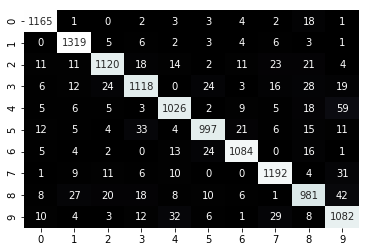

In [14]:
plot_and_update_confusion_for_all_steps(trial)